# Evaluate a Pre-Trained Segmentation Model on WHERD

Demonstrates image pre-processing, prediction and validation statistics. But first, some preliminaries...

__Note:__ To maintain a high priority Colab user status such that sufficient GPU resources are available in the future, ensure to free the runtime when finished running this notebook. This can be done using 'Runtime > Manage Sessions' and click 'Terminate'.

In [1]:
# Check if notebook is running in Colab or local workstation
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
    !pip install gputil
    !pip install psutil
    !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

try:
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[1]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm() 

    # Check if GPU capacity is sufficient to proceed
    if gpu.memoryFree < 10000:
        print("\nInsufficient memory! Some cells may fail. Please try restarting the runtime using 'Runtime → Restart Runtime...' from the menu bar. If that doesn't work, terminate this session and try again later.")
    else:
        print('\nGPU memory is sufficient to proceeed.')
except:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')

Gen RAM Free: 65.6 GB  | Proc size: 54.3 MB
GPU RAM Free: 11176MB | Used: 2MB | Util   0% | Total 11178MB

GPU memory is sufficient to proceeed.


In [2]:
if IN_COLAB:

    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'
    
    # cd into git repo so python can find utils
    %cd '/content/drive/My Drive/cciw-zebra-mussel/predict'

    sys.path.append('/content/drive/My Drive')
    
    # clone repo, install packages not installed by default
    !pip install pydensecrf

In [22]:
import os
import os.path as osp

import glob

# for manually reading high resolution images
import cv2 as cv
import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# pytorch core library
import torch
# pytorch neural network functions
from torch import nn
# pytorch dataloader
from torch.utils.data import DataLoader

# for post-processing model predictions by conditional random field 
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

from tqdm import tqdm  # progress bar

# evaluation metrics
from sklearn.metrics import r2_score
from sklearn.metrics import jaccard_score as jsc

# local imports (files provided by this repo)
import transforms as T

# various helper functions, metrics that can be evaluated on the GPU
from task_3_utils import mask_and_preds_to_1hot, evaluate, evaluate_loss, eval_binary_iou, pretty_image
#from task_3_utils import 

# Custom dataloader for rapidly loading images from a single LMDB file
from folder2lmdb import VOCSegmentationLMDB

sys.path.append("..") # Adds higher directory to python modules path.

from utils.dataset_2_utils import find_laser_beams
from utils.dataset_2_utils import colour_fmt_crop_and_resize

In [4]:
"""Confim that this cell prints "Found GPU, cuda". If not, select "GPU" as 
"Hardware Accelerator" under the "Runtime" tab of the main menu.
"""
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Found GPU,', device)

Found GPU, cuda


## 1. Load a pre-trained model checkpoint

In [5]:
os.environ['DATA_PATH'] = '/scratch/gallowaa/'

In [88]:
SEED = 2
CID = '564349c'

if IN_COLAB:
    root = osp.join(
        DATA_PATH, 'Checkpoints/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1')
    
else:
    root = osp.join(
        os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed%d/checkpoint' % SEED)
        #os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed%d/%s/checkpoint' % (SEED, CID))
    #root = osp.join(
    #    os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/deeplab/trainval_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint/')
    

#ckpt_file = 'deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed%d_epoch40.ckpt' % SEED
ckpt_file = 'deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed%d_epoch79.ckpt' % SEED
#ckpt_file = 'deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed%d_epoch40.ckpt' % SEED

model_to_load = osp.join(root, ckpt_file)
                         
print('Loading', model_to_load)                         
         
checkpoint = torch.load(model_to_load)
                        
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
print('==> Resuming from checkpoint..')
net = checkpoint['net']
last_epoch = checkpoint['epoch']
torch.set_rng_state(checkpoint['rng_state'])

# later appended to figure filenames
model_stem = ckpt_file.split('.')[0]

print('Loaded model %s trained to epoch ' % model_stem, last_epoch)
print(
    'Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

sig = nn.Sigmoid()  # initializes a sigmoid function

net.eval()

Loading /scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed2/checkpoint/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed2_epoch79.ckpt
==> Resuming from checkpoint..
Loaded model deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed2_epoch79 trained to epoch  79
Cross-entropy loss 0.1608 for train set, 0.9762 for validation set


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [7]:
sig = nn.Sigmoid()  # initializes a sigmoid function

## 7. i) Visualize Predictions on Whole Images

Here we manually load and preprocess the original images and png masks using OpenCV.

`root_path` -- will also be used in 

In [104]:
if IN_COLAB:
    root_path = osp.join(DATA_PATH, 'ADIG_Labelled_Dataset/Test/Lab/')
else:
    root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/'
    
# all files    
#jpeg_files = glob.glob(root_path + '*.jpg')
#png_files = glob.glob(root_path + '*_final.png')

# GoPro (1920x1080)
jpeg_files = glob.glob(root_path + '*GoPro*.jpg')
png_files = glob.glob(root_path + '*GoPro*_final.png')

# FishSens (1280x720)
#jpeg_files = glob.glob(root_path + '*FishSens*.jpg')
#png_files = glob.glob(root_path + '*FishSens*_final.png')

jpeg_files.sort()
png_files.sort()

# Both should equal 16 for all WHERD dataset
print(len(jpeg_files)) 
print(len(png_files))

10
10


In [105]:
jpeg_files

['/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_1353_2019-10-30_GoPro-8.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_1355_2019-10-30_GoPro-5.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_HP115410_2019-10-30_GoPro-3.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_HP131641_2019-11-03_GoPro-13.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_LEE06021_2019-10-30_GoPro-3.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_LEE06031_2019-10-30_GoPro-2.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_LEE06032_2019-11-03_GoPro-3.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_LEE06033_2019-10-30_GoPro-8.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_LEE06070_2019-10-30_GoPro-1.jpg',
 '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_LEE06075_2019-10-30_GoPro-11.jpg']

In [106]:
"""Set to True to save the model predictions in PNG format, 
otherwise proceed to predict biomass without saving images"""
PLOT = False
SAVE_PREDICTIONS = False

if SAVE_PREDICTIONS:
    prediction_path = ''
    for t in model_to_load.split('/')[:-1]:
    #for t in files[f].split('/')[:-1]:
        prediction_path += t + '/'

    prediction_path = osp.join(prediction_path, 'WHERD')

    if not osp.exists(prediction_path):
        os.mkdir(prediction_path)

    print(prediction_path)
    
    # src is the training dataset, tgt is the testing dataset
    src = 'train_v120'
    tgt = 'WHERD'

In [107]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

In [108]:
from task_3_utils import img_to_nchw_tensor

In [147]:
'''
search_scales = np.array([157,  # 1353
                          65,  # 1355
                          33,  # FS1355
                          40,  # FSHP131642
                          37,  # FSHP131645
                          55,  # FSHP131649 (55-115)
                          23,  # FSLEE06022
                          80,  # FSLEE06037 (40, 80, 110)
                          125,  # HP115410
                          100,  # HP131641
                          150,  # LEE06021
                          32,  # LEE06031 # (30-32, 60, 130)
                          100,  # LEE06032
                          100,  # LEE06033
                          100,  # LEE06070
                          60])  # LEE06075
'''
search_scales = np.array([157,  # 1353
                          65,  # 1355
                          125,  # HP115410
                          100,  # HP131641
                          150,  # LEE06021
                          32,  # LEE06031 # (30-32, 60, 130)
                          100,  # LEE06032
                          100,  # LEE06033
                          100,  # LEE06070
                          60])  # LEE06075

In [ ]:
for i in range(len(search_scales)):
    print(search_scales[i])

In [ ]:
# line search for optimal scale
i = 6
scales = np.arange(20, 150, 5)
#scales = np.arange(30, 65, 1)
image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

print(image_stem.split('_')[1])
for scale_percent in scales:
    
    img = resize(imgc, scale_percent)
    lab = resize(labc, scale_percent)
    
    nchw_tensor = img_to_nchw_tensor(img, device)
    with torch.no_grad():
        pred = sig(net(nchw_tensor)['out'])
    pred_np = pred.detach().cpu().numpy()
    mask = np.zeros((lab.shape[0], lab.shape[1]), dtype='float32')
    mask[lab[:, :, 0] == 128] = 1
    pred_np = pred_np.squeeze()
    targets = torch.LongTensor(mask)
    targets = targets.to(device)
    iou = eval_binary_iou(pred, targets).item()
    print(scale_percent, iou)

# Find laser beams in image

In [14]:
for i in range(2, 8):
    print(i, jpeg_files[i])

2 /scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FS1355_2019-11-03_FishSens-1.jpg
3 /scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSHP131642_2019-11-03_FishSens-4.jpg
4 /scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSHP131645_2019-11-03_FishSens-6.jpg
5 /scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSHP131649_2019-11-03_FishSens-2.jpg
6 /scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSLEE06022_2019-11-03_FishSens-1.jpg
7 /scratch/ssd/gallowaa/cciw/dataset_raw/Test/WHERD/all/WHERD_FSLEE06037_2019-11-03_FishSens-1.jpg


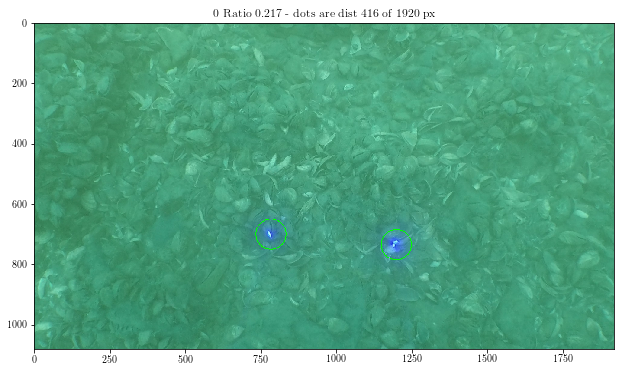

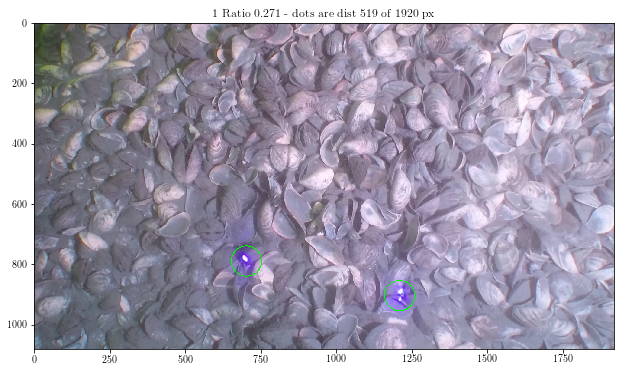

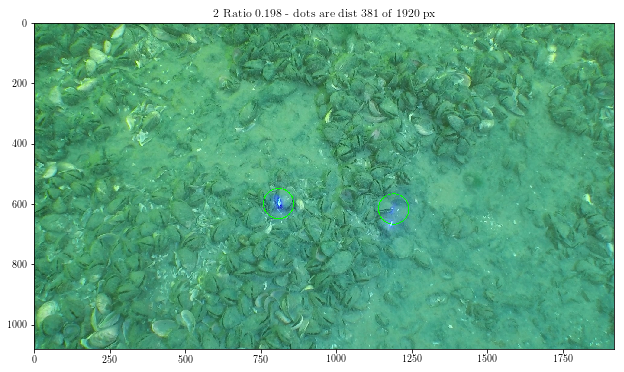

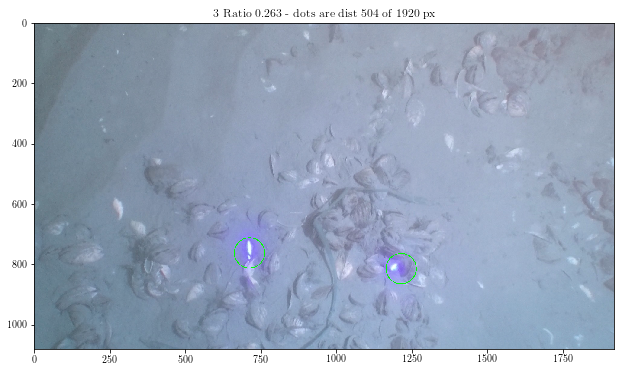

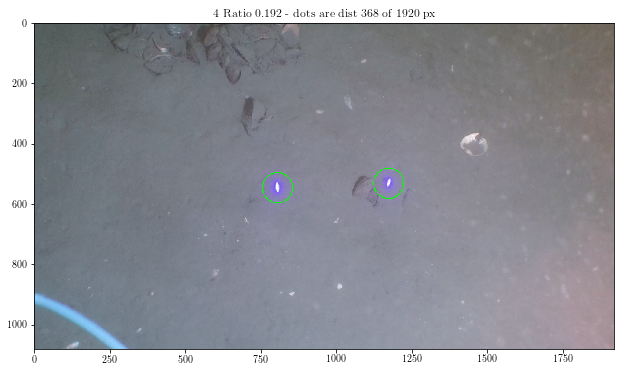

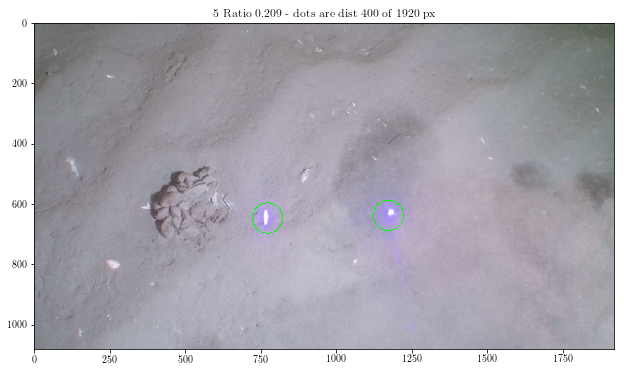

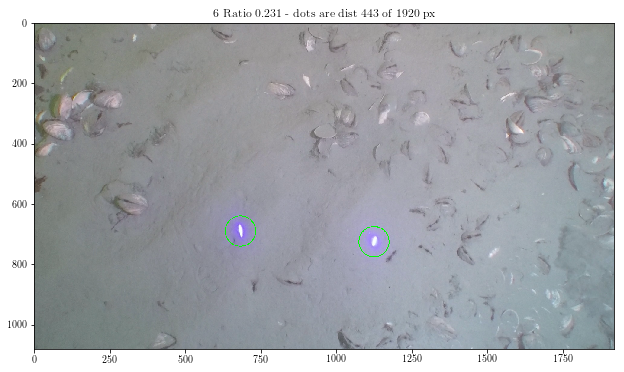

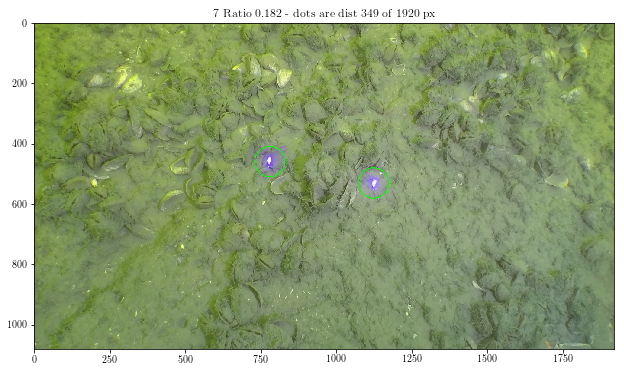

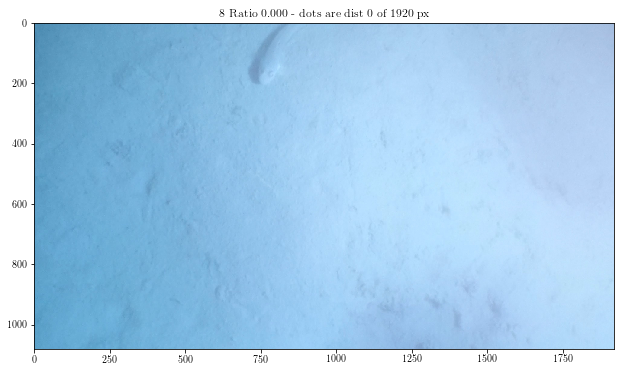

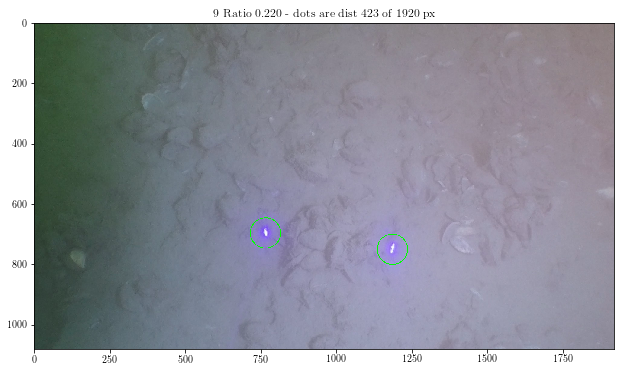

In [109]:
j = 0
laser_distances = []
for i in range(len(jpeg_files)):
#for i in range(2, 8):  # FishSens only
    f = jpeg_files[i]    
    im = cv.imread(f)  # im will be in BGR format
    coords = find_laser_beams(im)
    d = np.linalg.norm(coords[0] - coords[1])

    # draw the two clusters
    if (coords != -1).any():
        for pt in coords:
            _ = cv.circle(im, (int(pt[0]), int(pt[1])), 50, (0, 255, 0), 2) 
    
    laser_distances.append(d)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    title_str = '%d Ratio %.3f - dots are dist %d of %d px' % (
        j, d/im.shape[1], d, im.shape[1])
    ax.imshow(im)
    ax.set_title(title_str)
    plt.show()

    j += 1

In [110]:
jpeg_file_resolutions = []
for i in range(len(jpeg_files)):
#for i in range(2, 8):  # FishSens only
    jpeg_file_resolutions.append(np.prod(cv.imread(jpeg_files[i]).shape[:2]))

In [127]:
laser_distances = np.round(np.asarray(laser_distances), 3)
lasers_mask = laser_distances > 0
lasers = laser_distances[lasers_mask]
#lasers = laser_distances / laser_distances.max()
#lasers

In [128]:
jpeg_file_resolutions = np.asarray(jpeg_file_resolutions)
jpeg_file_resolutions = jpeg_file_resolutions / float(jpeg_file_resolutions.max())
res = jpeg_file_resolutions.copy()#[mask]

In [129]:
jpeg_file_resolutions

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [130]:
np.round(lasers, 2)

array([416.38, 519.8 , 381.06, 504.63, 368.66, 400.37, 443.23, 349.84,
       423.33])

In [131]:
# divide by the resolution so that less resolution = larger distance
d = 1. / lasers #/ res)
d = d / d.max()
#d /= 2
d

array([0.84019559, 0.67303319, 0.91808114, 0.69326696, 0.94895338,
       0.87379955, 0.78930044, 1.        , 0.8264038 ])

In [132]:
np.round(d, 2)*100

array([ 84.,  67.,  92.,  69.,  95.,  87.,  79., 100.,  83.])

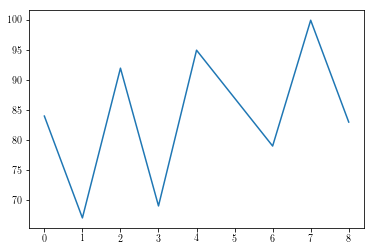

In [133]:
plt.plot(np.round(d, 2)*100)
#plt.plot(search_scales)

In [134]:
search_scales

array([157,  65,  33,  40,  37,  55,  23,  80, 125, 100, 150,  32, 100,
       100, 100,  60])

In [143]:
laser_scales = (d * 100).astype(int)
laser_scales

array([ 84,  67,  91,  69,  94,  87,  78, 100,  82])

In [136]:
IOU_C2 = False

In [141]:
iou_list = []
#scale_percent = 100
sub = 0

for i in range(len(jpeg_files)):
    image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
    bgr_lab = cv.imread(osp.join(root_path, png_files[i]))
    bgr_img = cv.imread(osp.join(root_path, jpeg_files[i]))

    seek_y = 0
    scale_percent = 100 
    '''
    if lasers_mask[i]:
        scale_percent = laser_scales[i - sub] # 100
    else:
        scale_percent = 100
        sub += 1
    '''

    img, mask = colour_fmt_crop_and_resize(
        bgr_img, bgr_lab, seek_y, scale_percent=scale_percent)

    nchw_tensor = img_to_nchw_tensor(img, device)

    with torch.no_grad():
        pred = sig(net(nchw_tensor)['out'])

    pred_np = pred.detach().cpu().numpy().squeeze()

    if IOU_C2:
        p_one_hot, t_one_hot = mask_and_preds_to_1hot(pred_np, mask)

        iou = jsc(p_one_hot.reshape(1, -1),
                  t_one_hot.reshape(1, -1), average='samples')
    else:
        targets = torch.LongTensor(mask).to(device)
        iou = eval_binary_iou(pred, targets).item()

    iou_list.append(iou)
    print('%d, %.4f' % (scale_percent, iou))
    #print('%.4f' % iou)

    if PLOT:
        # plt.close('all')
        fig, axes = plt.subplots(1, 1, figsize=(19.20, 10.80))
        p = (pred_np * 255).astype('uint8')
        src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
        src2[:, :, 2] = p
        dst = cv.addWeighted(img, 0.5, src2, 0.5, 0)
        axes.imshow(dst)
        axes.axis('off')
        plt.tight_layout()
    if SAVE_PREDICTIONS:
        filename = src + '__' + image_stem + '__' + model_stem + \
            '_scale%d_iou_%.4f' % (scale_percent, iou)
        out_file = osp.join(prediction_path, filename)
        fig.savefig(out_file + '.jpg', format='jpeg')

print("Average ", np.round(np.asarray(iou_list).mean(), 4))

100, 0.3493
100, 0.3169
100, 0.5419
100, 0.5075
100, 0.3498
100, 0.1588
100, 0.4385
100, 0.0663
100, 0.0000
100, 0.1948
Average  0.2924


# LOM: Figure 11

In [ ]:
from task_3_utils import mask_and_preds_to_1hot

In [78]:
scale_percent

27

In [68]:
laser_scales

array([33, 27, 50, 38, 23, 30])

4 0.2477533370256424


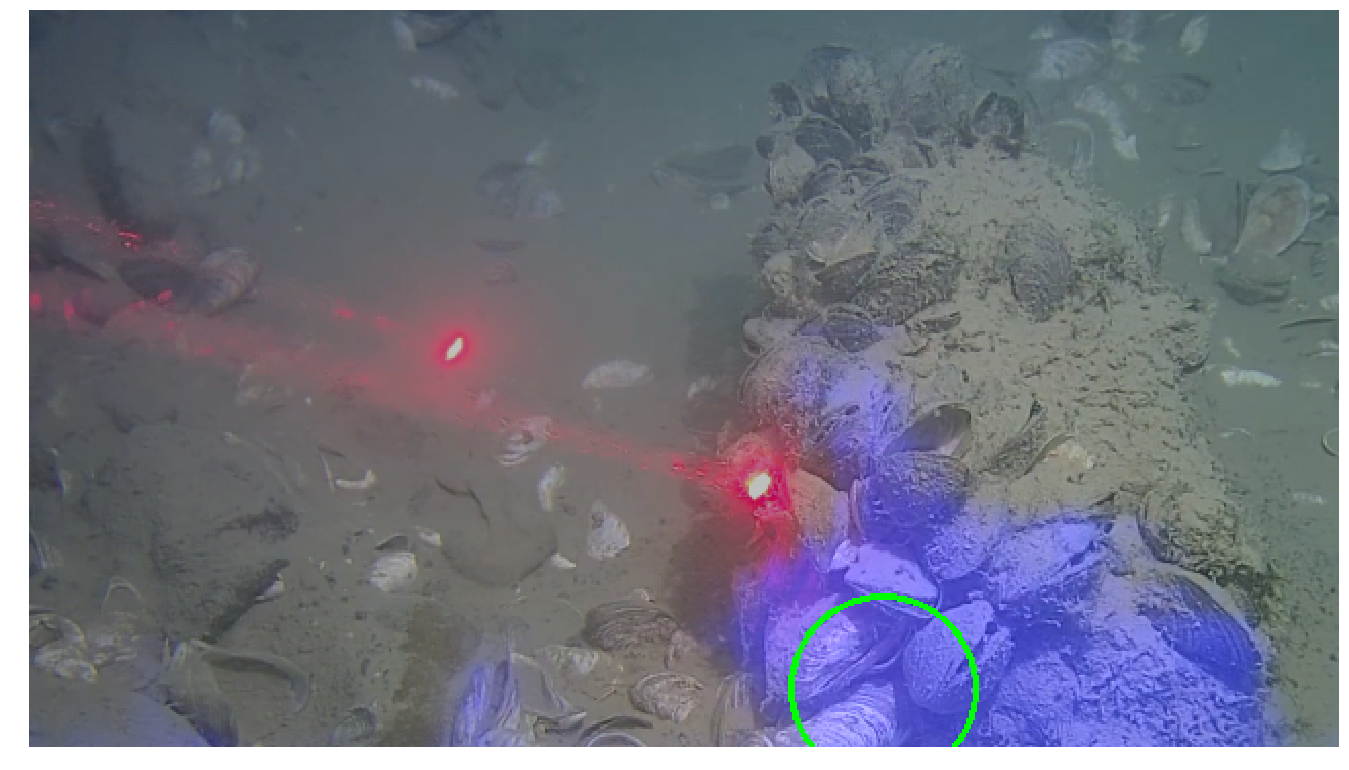

"\nif SAVE_PREDICTIONS:\n    filename = src + '__' + image_stem + '__' + model_stem + '_scale%d_iou_%.4f' % (scale_percent, iou)\n    out_file = osp.join(prediction_path, filename)\n    fig.savefig(out_file + '.jpg', format='jpeg')\n"

In [97]:
i = 4

image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
bgr_lab = cv.imread(osp.join(root_path, png_files[i]))
bgr_img = cv.imread(osp.join(root_path, jpeg_files[i]))

coords = find_laser_beams(bgr_img)

scale_percent = laser_scales[i - start_idx] 
#scale_percent = 40
img, mask = colour_fmt_crop_and_resize(
    bgr_img, bgr_lab, seek_y, scale_percent=scale_percent)

nchw_tensor = img_to_nchw_tensor(img, device)

with torch.no_grad():
    pred = sig(net(nchw_tensor)['out'])

pred_np = pred.detach().cpu().numpy().squeeze()

if IOU_C2:
    p_one_hot, t_one_hot = mask_and_preds_to_1hot(pred_np, mask)

    iou = jsc(p_one_hot.reshape(1, -1),
              t_one_hot.reshape(1, -1), average='samples')
else:
    targets = torch.LongTensor(mask).to(device)
    iou = eval_binary_iou(pred, targets).item()
    
# iou_list.append(iou)
print(i, iou)

plt.close('all')
fig, axes = plt.subplots(1, 1, figsize=(19.20, 10.80))
p = (pred_np * 255).astype('uint8')
src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv.addWeighted(img, 0.75, src2, 0.5, 0)

#d = np.linalg.norm(coords[0] - coords[1])

# draw the two clusters
if (coords != -1).any():
    for pt in coords:
        _ = cv.circle(dst, (int(pt[0]), int(pt[1])), 45, (0, 255, 0), 2)

axes.imshow(dst)
axes.axis('off')
plt.tight_layout()
plt.show()

'''
if SAVE_PREDICTIONS:
    filename = src + '__' + image_stem + '__' + model_stem + '_scale%d_iou_%.4f' % (scale_percent, iou)
    out_file = osp.join(prediction_path, filename)
    fig.savefig(out_file + '.jpg', format='jpeg')
'''

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 1, figsize=(12.80, 7.20))
p = (pred_np * 255).astype('uint8')
src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv2.addWeighted(img, 0.75, src2, 0.75, 0.25)
axes.imshow(dst)
axes.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
filename = 'fig5-' + src + '-' + tgt + '__' + image_stem + '__' + model_stem
out_file = osp.join(prediction_path, filename)
fig.savefig(out_file + '_scale%d.jpg' % scale_percent)

# LOM Journal, loop over all available seeds to find best laser scale

In [155]:
IOU_C2 = True

In [156]:
IOU_C2

True

In [157]:
root = osp.join(os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/')
files = glob.glob(
    root + 'deeplabv3_resnet50/*/*/*/*/*/checkpoint/*epoch79.ckpt')

start_idx = 2
nb_fish_sens = 6
sub = 0
for i in range(len(files)):

    # load checkpoint
    checkpoint = torch.load(files[i])
    train_loss = checkpoint['trn_loss']
    val_loss = checkpoint['val_loss']
    print("Loaded seed ", i + 1, np.round(train_loss, 4), np.round(val_loss, 4))
    net = checkpoint['net']
    net.eval()

    iou_list = []

    #for i in range(start_idx, start_idx + nb_fish_sens):  # FishSens only
    for i in range(len(jpeg_files)):
        image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
        bgr_lab = cv.imread(osp.join(root_path, png_files[i]))
        bgr_img = cv.imread(osp.join(root_path, jpeg_files[i]))

        seek_y = 0
        #scale_percent = 100 
        if lasers_mask[i]:
            #scale_percent = laser_scales[i - sub] # 100
            scale_percent = search_scales[i]
        else:
            scale_percent = 100
            sub += 1

        img, mask = colour_fmt_crop_and_resize(
            bgr_img, bgr_lab, seek_y, scale_percent=scale_percent)

        nchw_tensor = img_to_nchw_tensor(img, device)

        with torch.no_grad():
            pred = sig(net(nchw_tensor)['out'])

        pred_np = pred.detach().cpu().numpy().squeeze()

        if IOU_C2:
            p_one_hot, t_one_hot = mask_and_preds_to_1hot(pred_np, mask)

            iou = jsc(p_one_hot.reshape(1, -1),
                      t_one_hot.reshape(1, -1), average='samples')
        else:
            targets = torch.LongTensor(mask).to(device)
            iou = eval_binary_iou(pred, targets).item()

        iou_list.append(iou)
        #print('%d, %d, %.4f' % (i, scale_percent, iou))
        print('%.4f' % iou)

    print("Average ", np.round(np.asarray(iou_list).mean(), 4))

Loaded seed  1 0.1614 0.9776
0.3712
0.3245
0.4945
0.8013
0.9679
0.9882
0.8297
0.4441
0.9844
0.8001
Average  0.7006
Loaded seed  2 0.1608 0.9762
0.4554
0.1581
0.6603
0.7456
0.9291
0.9686
0.8256
0.4577
0.9911
0.7980
Average  0.699
Loaded seed  3 0.1598 0.9088
0.4270
0.3178
0.5602
0.7294
0.9642
0.9716
0.7944
0.4399
0.9691
0.7692
Average  0.6943


In [149]:
for i in range(len(search_scales)):
    print(search_scales[i])

157
65
125
100
150
32
100
100
100
60
